In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import os
import joblib
import warnings

In [10]:
data = pd.read_csv("..//data//GOOGL.csv",index_col="Date",parse_dates=True)
print(data.head())

                                Open       High        Low      Close  \
Date                                                                    
2006-01-27 05:00:00+00:00  10.873407  10.953894  10.722929  10.668937   
2006-01-30 05:00:00+00:00  10.729178  10.830414  10.623444  10.814915   
2006-01-31 05:00:00+00:00  10.762673  10.988390  10.597698  10.043029   
2006-02-01 05:00:00+00:00   9.724325  10.048527   9.686581   9.899549   
2006-02-02 05:00:00+00:00  10.094021  10.161011   9.898048   9.537352   

                               Volume  Day  DayOfWeek  Quarter  Month  Year  \
Date                                                                          
2006-01-27 05:00:00+00:00   337749912   27          4        1      1  2006   
2006-01-30 05:00:00+00:00   343212444   30          0        1      1  2006   
2006-01-31 05:00:00+00:00   881757360   31          1        1      1  2006   
2006-02-01 05:00:00+00:00  1083815100    1          2        1      2  2006   
2006-02-02 05:

### The following code uses last 60 days worth of data to predict the next day's closing price

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0019
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.0904e-05
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.9597e-05
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.0784e-05
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.2886e-05
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.5601e-05
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.5969e-05
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.7663e-05
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.8972e-05
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.3186e-05
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.1960e-05
Epoch 12/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.7715e-05
Epoch 13/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5769e-05
Epoch 14/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 4.

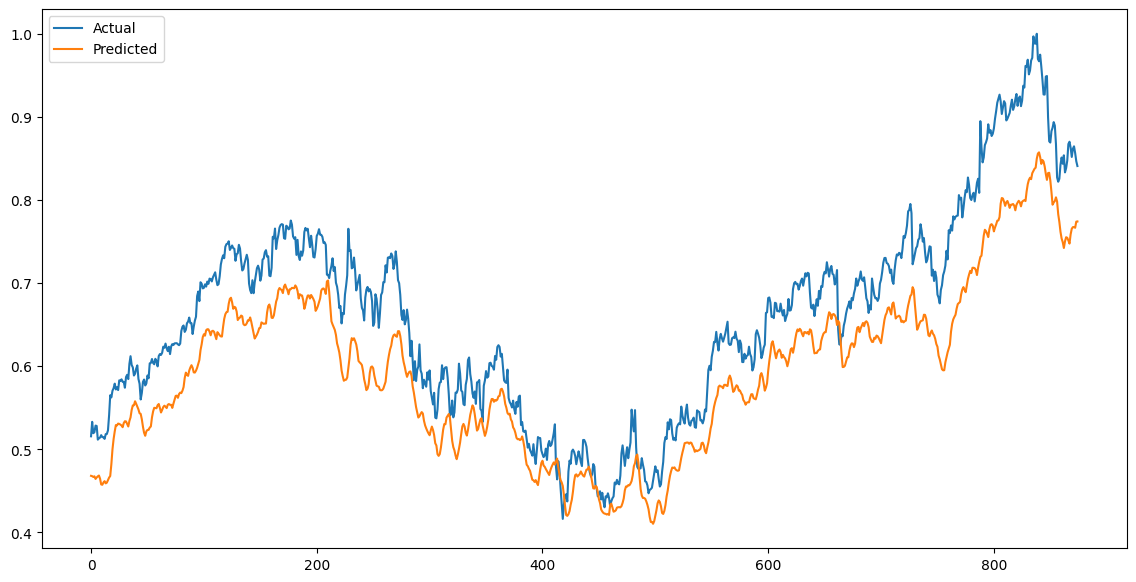

In [13]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
datetime_cols = df.select_dtypes(include=['datetime64']).columns

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[numeric_cols])

# Split the data into training and testing sets
train_size = int(0.8 * len(scaled_data)) # 80% of data is training set
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:] # Rest is test set

# Split the data into input (X) and output (y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 3])  # Use the 'Close' column as the output
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step) # Create 60 training samples from training set
X_test, y_test = create_dataset(test_data, time_step) 

# Reshape the data for the LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, test_predict)
print('MSE: ', mse)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.show()

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0042
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.6192e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.3762e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.7227e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.7512e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.9452e-04
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5667e-04
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.0162e-04
Epoch 9/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.9414e-04
Epoch 10/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.6703e-04
Epoch 11/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.5221e-04
Epoch 12/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.2888e-04
Epoch 13/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.8522e-04
Epoch 14/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.

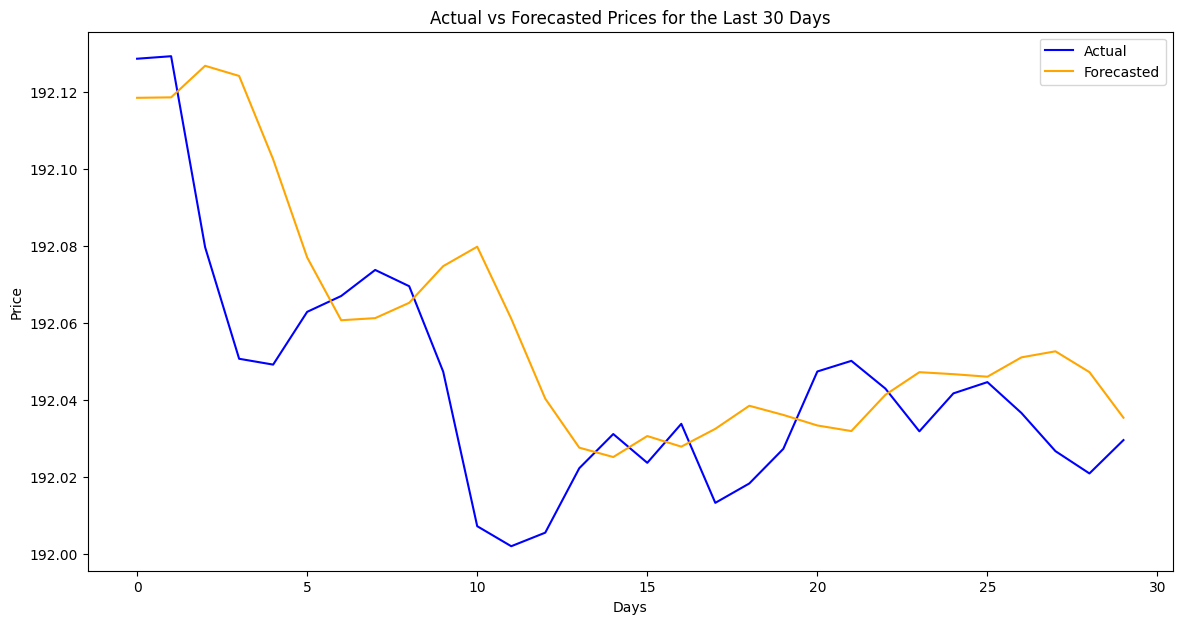

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# Sample dataframe creation (for context)
# Replace this with your actual data loading
# df = pd.read_csv('your_data.csv', parse_dates=True, index_col='Date')

# Select numeric and datetime columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
datetime_cols = df.select_dtypes(include=['datetime64']).columns

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[numeric_cols])

# Number of days to forecast
forecast_days = 30

# Split the data into training and testing sets
train_data, test_data = scaled_data[:-forecast_days], scaled_data[-(forecast_days + 60):]  # Take the last 60 days + forecast days for testing

# Function to create input (X) and output (y) datasets
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 3])  # Assuming the 4th column ('Close') is the target
    return np.array(X), np.array(y)

time_step = 60  # Number of time steps to consider for each sample
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Check if X_test and y_test are non-empty and have the correct shape before reshaping
if X_test.size == 0 or y_test.size == 0:
    print("Error: Not enough data points for testing. Adjust the forecast period or time step.")
else:
    # Reshape the data for the LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Forecast the next 30 days using the last available data
    test_predict = model.predict(X_test)

    # Scale back to original values
    test_predict_rescaled = scaler.inverse_transform(
        np.hstack((np.zeros((test_predict.shape[0], X_test.shape[2] - 1)), test_predict)))
    y_test_rescaled = scaler.inverse_transform(
        np.hstack((np.zeros((y_test.shape[0], X_test.shape[2] - 1)), y_test.reshape(-1, 1))))

    # Evaluate the model
    mse = mean_squared_error(y_test_rescaled[:, -1], test_predict_rescaled[:, -1])
    print('MSE: ', mse)

    # Plot actual vs forecasted values
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_test_rescaled)), y_test_rescaled[:, -1], label='Actual', color='blue')
    plt.plot(range(len(test_predict_rescaled)), test_predict_rescaled[:, -1], label='Forecasted', color='orange')
    plt.title('Actual vs Forecasted Prices for the Last 30 Days')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


MSE: 68.08914904894172


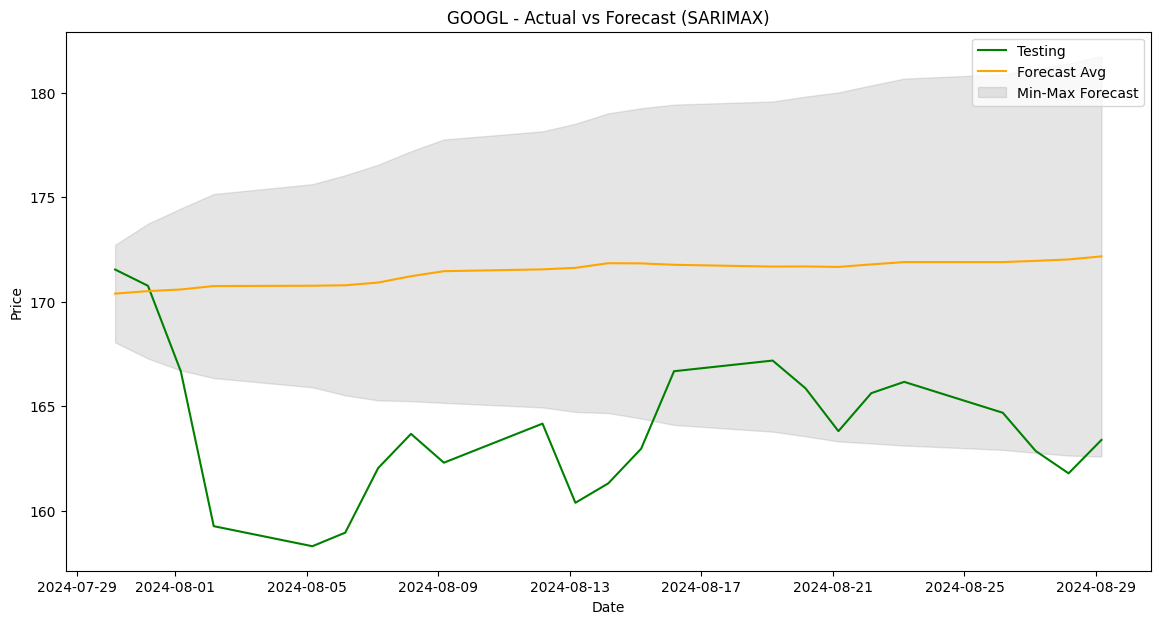

In [23]:
import statsmodels.api as sm
import warnings 

warnings.filterwarnings("ignore")

def train_sarimax(data, stock):
    data['Date'] = pd.to_datetime(data.index).tz_localize(None)
    data['Close'] = data['Close'].astype(float)
    
    train_data = data[data['Date'] <= '2024-07-30']
    test_data = data[data['Date'] > '2024-07-30']
    
    # SARIMAX Model
    model = sm.tsa.statespace.SARIMAX(train_data['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Forecasting
    forecast = model_fit.get_forecast(steps=len(test_data))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    forecast_min = conf_int.iloc[:, 0]
    forecast_max = conf_int.iloc[:, 1]
    
    mse = mean_squared_error(test_data['Close'], forecast_mean)
    print("MSE:", mse)
    
    # Plotting the Results
    plt.figure(figsize=(14, 7))
    # plt.plot(train_data['Date'], train_data['Close'], label='Training', color='blue')
    plt.plot(test_data['Date'], test_data['Close'], label='Testing', color='green')
    plt.plot(test_data['Date'], forecast_mean, label='Forecast Avg', color='orange')
    plt.fill_between(test_data['Date'], forecast_min, forecast_max, color='gray', alpha=0.2, label='Min-Max Forecast')
    plt.title(f'{stock} - Actual vs Forecast (SARIMAX)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

train_sarimax(data,"GOOGL")

In [25]:
def train_markov_chain(df, stock_name, forecast_days=30):
    """
    Trains a Markov Chain model on the given data and forecasts the next `forecast_days` days.

    Parameters:
        df (pd.DataFrame): The input dataframe with datetime index and numeric columns.
        stock_name (str): The name of the stock to use in saving the model files.
        forecast_days (int): The number of days to forecast. Default is 30.

    Returns:
        None: Displays the plot of actual vs forecasted values, prints the MSE, and saves the model.
    """
    # Selecting numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[numeric_cols])

    # Splitting the data into training and testing sets
    train_data, test_data = scaled_data[:-forecast_days], scaled_data[-forecast_days:]

    # Create a Markov Chain model
    transition_matrix = np.zeros((len(train_data), len(train_data)))
    for i in range(len(train_data) - 1):
        transition_matrix[i, np.argmax(train_data[i + 1])] += 1

    # Normalize the transition matrix
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # Forecast the next `forecast_days` using the Markov Chain model
    forecasted_values = np.zeros(forecast_days)
    current_state = train_data[-1]
    for i in range(forecast_days):
        next_state = np.random.choice(len(train_data), p=transition_matrix[np.argmax(current_state)])
        forecasted_values[i] = train_data[next_state]
        current_state = train_data[next_state]

    # Scale back to original values
    forecasted_values_rescaled = scaler.inverse_transform(forecasted_values.reshape(-1, 1))
    actual_values_rescaled = scaler.inverse_transform(test_data[:, -1].reshape(-1, 1))

    # Evaluate the model
    mse = mean_squared_error(actual_values_rescaled, forecasted_values_rescaled)
    print(f'MSE for {stock_name}: ', mse)

    # # Save the model
    # model_path = os.path.join(model_dir, f"{stock_name}_markov_chain_model.joblib")
    # joblib.dump((scaler, transition_matrix), model_path)
    # print(f"Model saved for {stock_name} at {model_path}.")

    # Plot actual vs forecasted values
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(actual_values_rescaled)), actual_values_rescaled, label='Actual', color='blue')
    plt.plot(range(len(forecasted_values_rescaled)), forecasted_values_rescaled, label='Forecasted', color='orange')
    plt.title(f'Actual vs Forecasted Prices for {stock_name} - Last {forecast_days} Days')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


train_markov_chain(data,"GOOGL")



ValueError: setting an array element with a sequence.

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def lstm_forecast(df, forecast_days=30, target_col='Close', time_steps=60, epochs=20):
    """
    Trains an LSTM model on the entire dataset and forecasts the next `forecast_days` closing prices.

    Parameters:
        df (pd.DataFrame): Input dataframe containing historical stock data with datetime index.
        forecast_days (int): The number of future days to forecast. Default is 30.
        target_col (str): Column name of the target variable (e.g., 'Close'). Default is 'Close'.
        time_steps (int): The number of time steps to consider for each input sample. Default is 60.
        epochs (int): The number of epochs for training the LSTM model. Default is 20.

    Returns:
        pd.DataFrame: A dataframe containing the historical and forecasted closing prices.
    """
    # Selecting the target column
    data = df[[target_col]].values

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Function to create input (X) and output (y) datasets
    def create_dataset(data, time_step=1):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    # Create the training data
    X, y = create_dataset(scaled_data, time_steps)

    # Reshape the data for the LSTM
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=1)

    # Prepare data for forecasting
    last_data = scaled_data[-time_steps:]  # Get the last `time_steps` values
    forecast_input = last_data.reshape(1, time_steps, 1)

    # Forecast future prices
    forecast = []
    for _ in range(forecast_days):
        next_pred = model.predict(forecast_input)[0][0]
        forecast.append(next_pred)

        # Update the forecast input with the new prediction
        forecast_input = np.append(forecast_input[:, 1:, :], [[[next_pred]]], axis=1)

    # Rescale the forecast back to original scale
    forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    # Create a date index for the forecasted values
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date, periods=forecast_days + 1, freq='B')[1:]

    # Create a dataframe to combine historical and forecasted data
    forecast_df = pd.DataFrame(data=forecast_rescaled, index=future_dates, columns=[target_col])

    # Combine historical and forecast data
    combined_df = pd.concat([df[[target_col]], forecast_df])

    # Plot the historical and forecasted values
    plt.figure(figsize=(14, 7))
    plt.plot(combined_df.index, combined_df[target_col], label='Actual and Forecasted Prices', color='blue')
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f'{target_col} - Historical and {forecast_days}-Day Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    return combined_df

# Example usage:
if __name__ == "__main__":
    # Replace 'AAPL.csv' with the path to your data file
    data_path = "../data/GOOGL.csv"
    data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

    # Forecast the next 30 days
    forecast_days = 180
    result_df = lstm_forecast(data, forecast_days=forecast_days, target_col='Close')

    print(result_df.tail(forecast_days))


Epoch 1/20
